In [1]:
#Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
from keras.preprocessing import sequence
from keras.models import Sequential,load_model
from keras.layers import Input,Dense,Dropout, Embedding
from keras.layers import LSTM
from keras.optimizers import Adam
import warnings
import livelossplot
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
warnings.filterwarnings("ignore")

/Users/pavithra/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
#Funcation to load the train, labels and test files
def load_data():
    features = pd.read_csv('data/features.csv')
    labels = pd.read_csv('data/labels.csv')
    test_data = pd.read_csv('data/test.csv')
    return features,labels,test_data

# Function gets the dataset, preprocess it and sends back the final dataset
def get_dataset():
    features,labels,test_data = load_data()
    train_data,test_data = preprocess_data(features,labels,test_data)
    X_train = train_data
    Y_train = train_data.iloc[:,157:]
    X_test = test_data
    return X_train, Y_train,X_test

#Function implements preprocessing of removing null value records and reset index 
def preprocess_data(features,labels,test_data):
    train_data = pd.merge(features,labels,on='trackID',how="left")
    train_data.dropna(inplace = True)
    train_data.reset_index(drop=True, inplace=True)
    test_data.dropna(inplace = True)
    test_data.reset_index(drop=True, inplace=True)
    return train_data, test_data

#Function to visualize and attain deeper knowledge on data
def genre_spread(data):
    #Plot to visualize Percentage of different Genre types
    fig, ax = plt.subplots(figsize=(20,10))
    plot = sns.countplot(x='genre', palette="Blues_r", data=data, order = data['genre'].value_counts().index)
    plt.title('Percentage of Genre type', fontsize=40)
    for i in ax.patches:
        ax.annotate(f'{i.get_height() * 100 / data.shape[0]:.2f}%',
                (i.get_x() + i.get_width() / 2., i.get_height()), 
                ha='center', 
                va='center', 
                fontsize=15, 
                color='red',
                xytext=(0,7), 
                textcoords='offset points')
        
    print('Genre Classic pop and rock and folk generates 40% of our data. (Most Preferred)')
    print('Genre jazz and blues are the least preferred genre')
    
def distribution_viz(data):       
    #Plot to visualize Distribution of column values by genre 
    #This is plotted only for columns which had proper meaning
    plt.title("Distribution of values by genre", fontsize = 18)
    for col in list(data.iloc[:, 3:9].columns):
        for i in data['genre'].unique():
            sns.kdeplot(data=data.loc[data['genre']==i, col], label=i)
        plt.xlabel(col, fontsize = 20)
        plt.legend()
        plt.show()
        
def outlier_viz(data):    
    #Visualisation to study outliers in features
    #This is plotted only for columns
    for col in list(data.iloc[:, 3:10].columns):
        fig, ax = plt.subplots(figsize=(10,5))
        sns.boxplot(x=data[col])
        plt.xlabel(col, fontsize = 20)
        plt.show()
        
#Writing different functions for correlation, only to visualize in a better way in jupyter notebook
def corr_viz1(data):
    #Correlation between all 154 continuous variables 
    correlations = data.iloc[:, 3:154].corr()

    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()
    
#Better visualization of Correlation of features having high correlation in previous plot 
def corr_viz2(data):
    correlations = data.iloc[:, 37:67].corr()

    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()

def corr_viz3(data):
    correlations = data.iloc[:, 67:97].corr()

    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()
    
def corr_viz4(data):
    correlations = data.iloc[:, 97:127].corr()

    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()

def corr_viz5(data):
    correlations = data.iloc[:, 127:157].corr()

    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()

#Function to plot the feature 'tempo's importance over the target value
def imp_fea_viz1(data):
    plt.figure(figsize=(14,8))
    plot = sns.barplot(x=data["genre"], y=data["tempo"],palette = 'husl')
    plt.title('Impact of feature tempo on Genre type', fontsize=40)
    ax = plot.axes
    plt.show()
    
#Function to plot the feature 'vect_41's importance over the target value
def imp_fea_viz2(data):
    plt.figure(figsize=(14,8))
    plot = sns.barplot(x=data["genre"], y=data["vect_41"],palette = 'husl')
    plt.title('Impact of  feature vect_41 on Genre type', fontsize=40)
    ax = plot.axes
    plt.show()
    
#Function to plot the feature 'loudness's importance over the target value
def imp_fea_viz3(data):
    plt.figure(figsize=(14,8))
    plot = sns.barplot(x=data["genre"], y=data["loudness"],palette = 'husl')
    plt.title('Impact of  feature loudness on Genre type', fontsize=40)
    ax = plot.axes
    plt.show()

#Function to summarize the shapes of input and put dataframe before sending it to the target CNN model 
def data_summary(X_train, Y_train, X_val, Y_val,X_test):
    """Summarize current state of dataset"""
    print('Train features shape:', X_train.shape)
    print('Train labels shape:', Y_train.shape)
    print('Validation features shape:', X_val.shape)
    print('Validation labels shape:', Y_val.shape)
    print('Test features shape:', X_test.shape)
    
# Function gets a list of models to evaluate for feature importance
# This will later help to build the final Logistic Regression model
def get_models():
    models = dict()
    for i in range(3,154):
        steps = [('norm', preprocessing.MinMaxScaler()),('pca', PCA(n_components=i)), ('m', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps)
    return models

# evaluate a given model using cross-validation for feature importance
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores



In [3]:
# explore dataset
features,labels,test_data = load_data()
features.shape

(8128, 157)

There are 8128 rows ans 157 columns in our features dataset

In [4]:
#Describe the dataset to know about the mean distribution
features.describe()

trackID     loudness        tempo  time_signature          key  \
count  8128.000000  8118.000000  8117.000000     8119.000000  8113.000000   
mean   4277.619341    -9.528668   125.731032        3.570144     5.239492   
std    2473.352897     4.402895    34.672811        1.195778     3.591466   
min       0.000000   -35.726000     0.000000        0.000000     0.000000   
25%    2133.750000   -12.197000    99.836000        3.000000     2.000000   
50%    4276.500000    -8.741500   121.773000        4.000000     5.000000   
75%    6419.250000    -6.120000   146.929000        4.000000     9.000000   
max    8555.000000    -0.414000   253.036000        7.000000    11.000000   

              mode     duration       vect_1       vect_2       vect_3  ...  \
count  8119.000000  8119.000000  8118.000000  8120.000000  8117.000000  ...   
mean      0.684813   238.529555    43.676100     3.925979     8.670058  ...   
std       0.464619    88.411735     5.656777    48.410113    29.747908  ...   
min       0.000000     5.276280    17.606993  -289.862566  -140.558193  ...   
25%       0.000000   186.200360    40.056564   -26.148983    -8.704819  ...   
50%       1.000000   228.048530    44.151439     8.617554    10.006663  ...   
75%       1.000000   275.317100    48.003362    38.102432    27.194705  ...   
max       1.000000  1271.718730    55.564543   150.885303   157.483210  ...   

          vect_139     vect_140     vect_141     vect_142     vect_143  \
count  8125.000000  8127.000000  8127.000000  8126.000000  8128.000000   
mean      0.000717     0.000766     0.000792     0.000816     0.000812   
std       0.000652     0.000687     0.000714     0.000723     0.000718   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000279     0.000299     0.000305     0.000319     0.000317   
50%       0.000560     0.000595     0.000610     0.000634     0.000632   
75%       0.000917     0.000987     0.001022     0.001052     0.001052   
max       0.006545     0.006613     0.006698     0.006682     0.006645   

          vect_144     vect_145     vect_146     vect_147     vect_148  
count  8128.000000  8128.000000  8128.000000  8128.000000  8128.000000  
mean      0.000781     0.000746     0.000697     0.194084     5.181209  
std       0.000711     0.000686     0.000648     0.086342    41.428973  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000299     0.000292     0.000274     0.129872     0.733115  
50%       0.000598     0.000568     0.000530     0.179694     1.590191  
75%       0.000999     0.000946     0.000872     0.245001     3.743055  
max       0.006777     0.006770     0.006632     0.767182  3193.622527  

[8 rows x 155 columns]

In [5]:
#Study of null values in the features data
features.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 157 columns):
 #    Column          Non-Null Count  Dtype  
---   ------          --------------  -----  
 0    trackID         8128 non-null   int64  
 1    title           8121 non-null   object 
 2    tags            8116 non-null   object 
 3    loudness        8118 non-null   float64
 4    tempo           8117 non-null   float64
 5    time_signature  8119 non-null   float64
 6    key             8113 non-null   float64
 7    mode            8119 non-null   float64
 8    duration        8119 non-null   float64
 9    vect_1          8118 non-null   float64
 10   vect_2          8120 non-null   float64
 11   vect_3          8117 non-null   float64
 12   vect_4          8116 non-null   float64
 13   vect_5          8119 non-null   float64
 14   vect_6          8116 non-null   float64
 15   vect_7          8118 non-null   float64
 16   vect_8          8120 non-null   float64
 17   vect_9      

As there are less than 5% of null values in every column, eliminate those records while data preprocessing

In [6]:
#Study of null values in the labels data
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   trackID  8128 non-null   int64 
 1   genre    8128 non-null   object
dtypes: int64(1), object(1)
memory usage: 127.1+ KB


In [7]:
#Get to know the distribution of records across label values
#This will help us understand the skewness of data over one particular target value
labels['genre'].value_counts()

classic pop and rock     1684
folk                     1665
metal                    1209
soul and reggae           988
punk                      981
pop                       731
dance and electronica     523
jazz and blues            347
Name: genre, dtype: int64

In [8]:
#load the processed data
X_train, Y_train, X_test = get_dataset()

In [9]:
X_train

trackID                                 title  \
0        6654                Beside the Yellow Line   
1        3424                         Calabria 2008   
2        5434  Verbal Abuse (Just an American Band)   
3         516                         Helen Of Troy   
4        4906             Only Him Or Me - Original   
...       ...                                   ...   
7719     1802                         Baby Don't Go   
7720     3397            Silhouette (Album Version)   
7721     1760        I Just Wanna Have Sex With You   
7722     2114                           Cay's Crays   
7723     2252                 Whenever You're Ready   

                                                   tags  loudness    tempo  \
0     i, the, to, and, a, me, it, not, in, my, is, o...    -8.539  104.341   
1     i, the, you, to, and, a, me, it, not, in, of, ...    -9.637  126.003   
2     i, you, to, and, a, me, it, not, my, is, your,...   -10.969  197.625   
3     i, the, to, a, me, it, not, in, is, your, we, ...    -5.369  170.008   
4     i, the, you, to, and, a, me, it, not, in, is, ...   -16.516  142.254   
...                                                 ...       ...      ...   
7719  i, the, you, to, and, a, me, it, not, in, is, ...   -13.483  117.425   
7720  i, the, you, to, and, a, me, it, not, in, my, ...   -11.508   90.552   
7721  i, the, you, me, it, not, in, my, is, your, do...    -1.503  121.536   
7722  i, the, you, and, it, in, my, is, of, your, th...   -15.945  129.310   
7723  i, you, to, and, a, me, not, in, is, do, are, ...   -11.594   93.081   

      time_signature   key  mode   duration     vect_1  ...  vect_140  \
0                3.0   7.0   1.0  298.73587  44.462048  ...  0.000302   
1                4.0  10.0   0.0  412.94322  40.376622  ...  0.001039   
2                4.0   2.0   1.0   64.78322  45.598532  ...  0.000284   
3                4.0   0.0   1.0  191.97342  47.159148  ...  0.000927   
4                5.0   4.0   1.0  146.75546  36.712606  ...  0.000130   
...              ...   ...   ...        ...        ...  ...       ...   
7719             4.0   0.0   1.0  197.53751  39.984047  ...  0.000614   
7720             3.0   9.0   1.0  259.36934  39.272394  ...  0.001331   
7721             1.0   2.0   1.0   55.90159  53.644921  ...  0.001609   
7722             4.0   4.0   1.0  375.37914  32.199930  ...  0.000296   
7723             3.0   0.0   1.0  154.17424  42.784899  ...  0.000282   

      vect_141  vect_142  vect_143  vect_144  vect_145  vect_146  vect_147  \
0     0.000302  0.000315  0.000297  0.000305  0.000266  0.000225  0.130826   
1     0.001116  0.001166  0.001159  0.001110  0.001015  0.000895  0.116206   
2     0.000313  0.000325  0.000324  0.000299  0.000273  0.000236  0.163738   
3     0.000994  0.001037  0.001051  0.001011  0.000962  0.000898  0.108193   
4     0.000132  0.000124  0.000117  0.000109  0.000107  0.000114  0.131246   
...        ...       ...       ...       ...       ...       ...       ...   
7719  0.000633  0.000637  0.000634  0.000633  0.000613  0.000588  0.149750   
7720  0.001404  0.001448  0.001455  0.001431  0.001375  0.001291  0.077494   
7721  0.001584  0.002127  0.001386  0.001560  0.002559  0.002041  0.305190   
7722  0.000323  0.000344  0.000348  0.000333  0.000305  0.000267  0.178468   
7723  0.000267  0.000275  0.000256  0.000212  0.000188  0.000191  0.184350   

      vect_148                  genre  
0     1.071914                   folk  
1     0.306846        soul and reggae  
2     1.247803                   punk  
3     0.366419  dance and electronica  
4     0.693531                   folk  
...        ...                    ...  
7719  1.077480                   folk  
7720  0.303018                   folk  
7721  7.420716                   punk  
7722  0.712929        soul and reggae  
7723  0.919770   classic pop and rock  

[7724 rows x 158 columns]

Genre Classic pop and rock and folk generates 40% of our data. (Most Preferred)
Genre jazz and blues are the least preferred genre


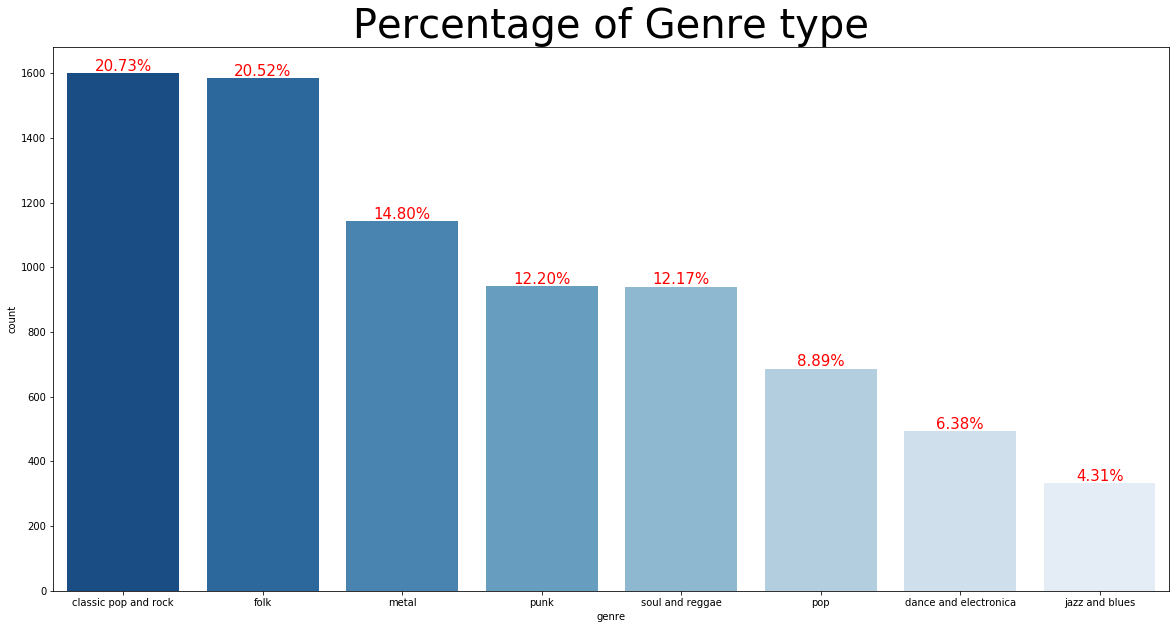

In [10]:
genre_spread(X_train)

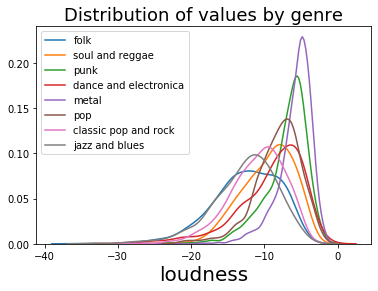

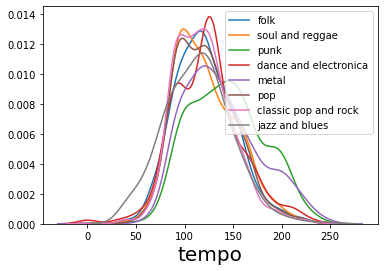

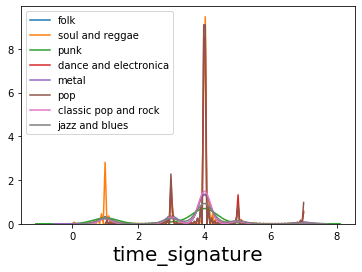

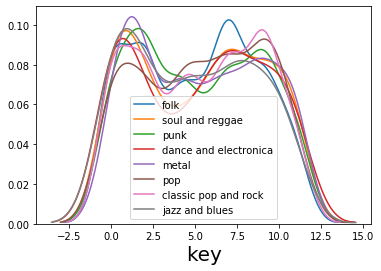

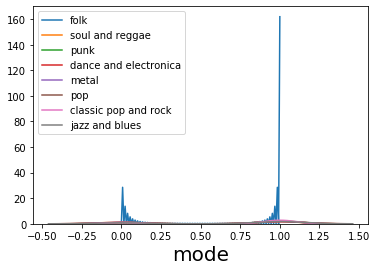

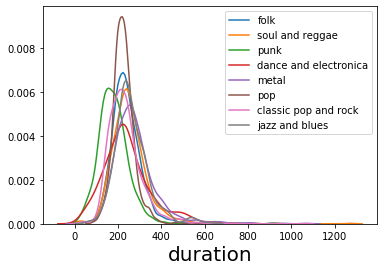

In [11]:
distribution_viz(X_train)

- TIME SIGNATURE:
    * Most of the songs have time signature of 4 minutes
- LOUDNESS:
    * Folk - LEAST loud genre
    * Metal - MOST (LOUDEST) genre
- TEMPO:
    * Is normally high between 50 - 200

# Check for Outliers



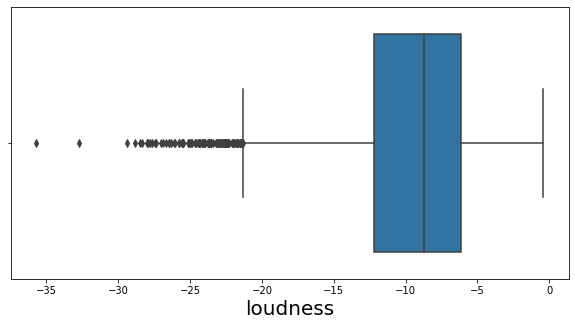

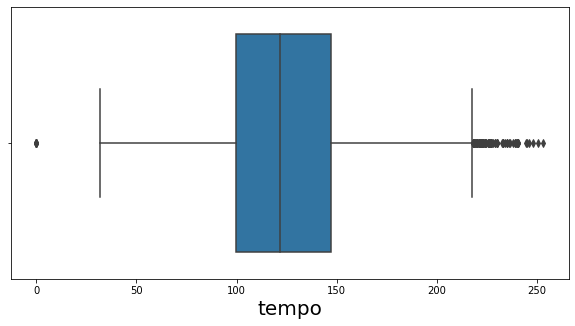

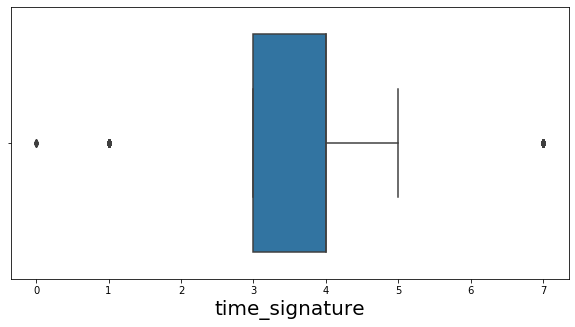

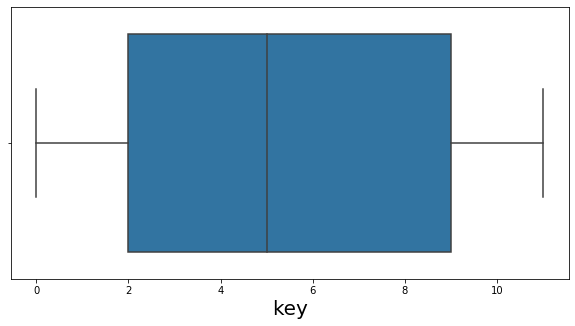

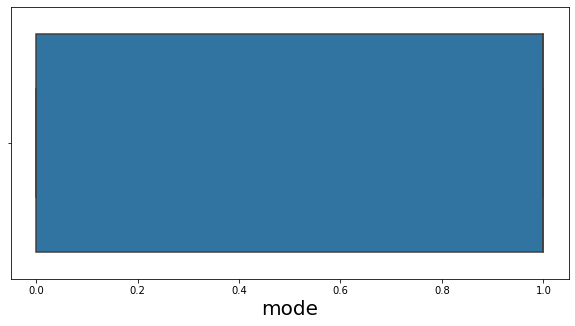

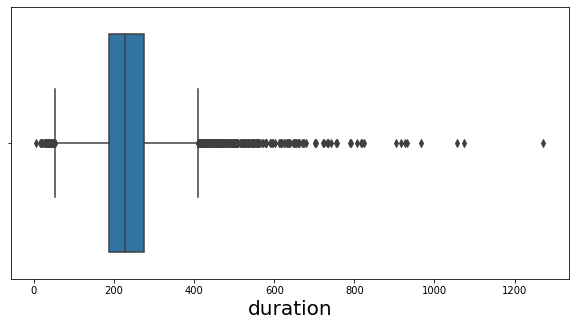

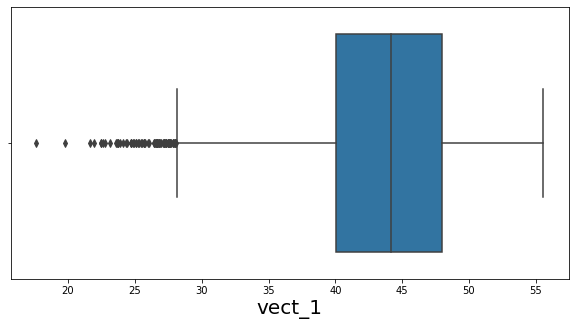

In [12]:
outlier_viz(X_train)

The above box plot, gives information about outliers, but it doesnt provide detailed information of the outlier datapoint.

In [13]:
X_train[(np.abs(stats.zscore(X_train.iloc[:,3:154])) < 3).all(axis=1)].iloc[:,3:154]

loudness    tempo  time_signature  key  mode   duration     vect_1  \
0       -8.539  104.341             3.0  7.0   1.0  298.73587  44.462048   
6       -2.318  214.750             3.0  8.0   1.0  304.19546  53.593368   
8      -17.045  100.165             4.0  0.0   1.0  207.72526  35.947064   
10     -13.986  144.059             4.0  7.0   1.0  255.42485  36.893712   
14      -4.916  104.968             4.0  5.0   1.0  212.42730  47.919988   
...        ...      ...             ...  ...   ...        ...        ...   
7714    -5.870   94.899             4.0  0.0   1.0  223.79057  49.734186   
7718   -12.624  124.178             4.0  7.0   1.0  234.70975  41.523499   
7719   -13.483  117.425             4.0  0.0   1.0  197.53751  39.984047   
7720   -11.508   90.552             3.0  9.0   1.0  259.36934  39.272394   
7723   -11.594   93.081             3.0  0.0   1.0  154.17424  42.784899   

          vect_2     vect_3     vect_4  ...  vect_136  vect_137  vect_138  \
0     -13.499814  26.257028  -2.794023  ...  0.000276  0.000293  0.000311   
6     102.233676  19.721500  -0.350612  ...  0.000680  0.000625  0.000806   
8     -58.884574  -5.399089 -12.158480  ...  0.000035  0.000035  0.000041   
10     52.102866 -32.498138 -27.491704  ...  0.000044  0.000048  0.000054   
14     64.390962  18.738763  32.971440  ...  0.001038  0.001019  0.001090   
...          ...        ...        ...  ...       ...       ...       ...   
7714   25.238475  33.821451  -2.705847  ...  0.000454  0.000507  0.000560   
7718  -20.188191   8.638341 -10.189424  ...  0.000312  0.000417  0.000388   
7719  -29.873895  16.388624  -3.624151  ...  0.000523  0.000502  0.000536   
7720  -26.411095 -54.721705  -8.332000  ...  0.001088  0.001046  0.001149   
7723   -8.480427  -7.134557 -12.212979  ...  0.000233  0.000268  0.000298   

      vect_139  vect_140  vect_141  vect_142  vect_143  vect_144  vect_145  
0     0.000308  0.000302  0.000302  0.000315  0.000297  0.000305  0.000266  
6     0.001030  0.001201  0.001334  0.001403  0.001417  0.001354  0.001192  
8     0.000044  0.000047  0.000050  0.000052  0.000052  0.000050  0.000046  
10    0.000050  0.000061  0.000051  0.000046  0.000042  0.000041  0.000041  
14    0.001151  0.001226  0.001246  0.001245  0.001224  0.001259  0.001239  
...        ...       ...       ...       ...       ...       ...       ...  
7714  0.000522  0.000547  0.000544  0.000574  0.000594  0.000526  0.000548  
7718  0.000409  0.000408  0.000425  0.000428  0.000392  0.000343  0.000348  
7719  0.000580  0.000614  0.000633  0.000637  0.000634  0.000633  0.000613  
7720  0.001244  0.001331  0.001404  0.001448  0.001455  0.001431  0.001375  
7723  0.000293  0.000282  0.000267  0.000275  0.000256  0.000212  0.000188  

[5288 rows x 151 columns]

As the outliers contribute to 34% of our entire dataset, we maintain the outlier as it is. ** This should be informed to the respective business team / stakeholders in real life scenario **

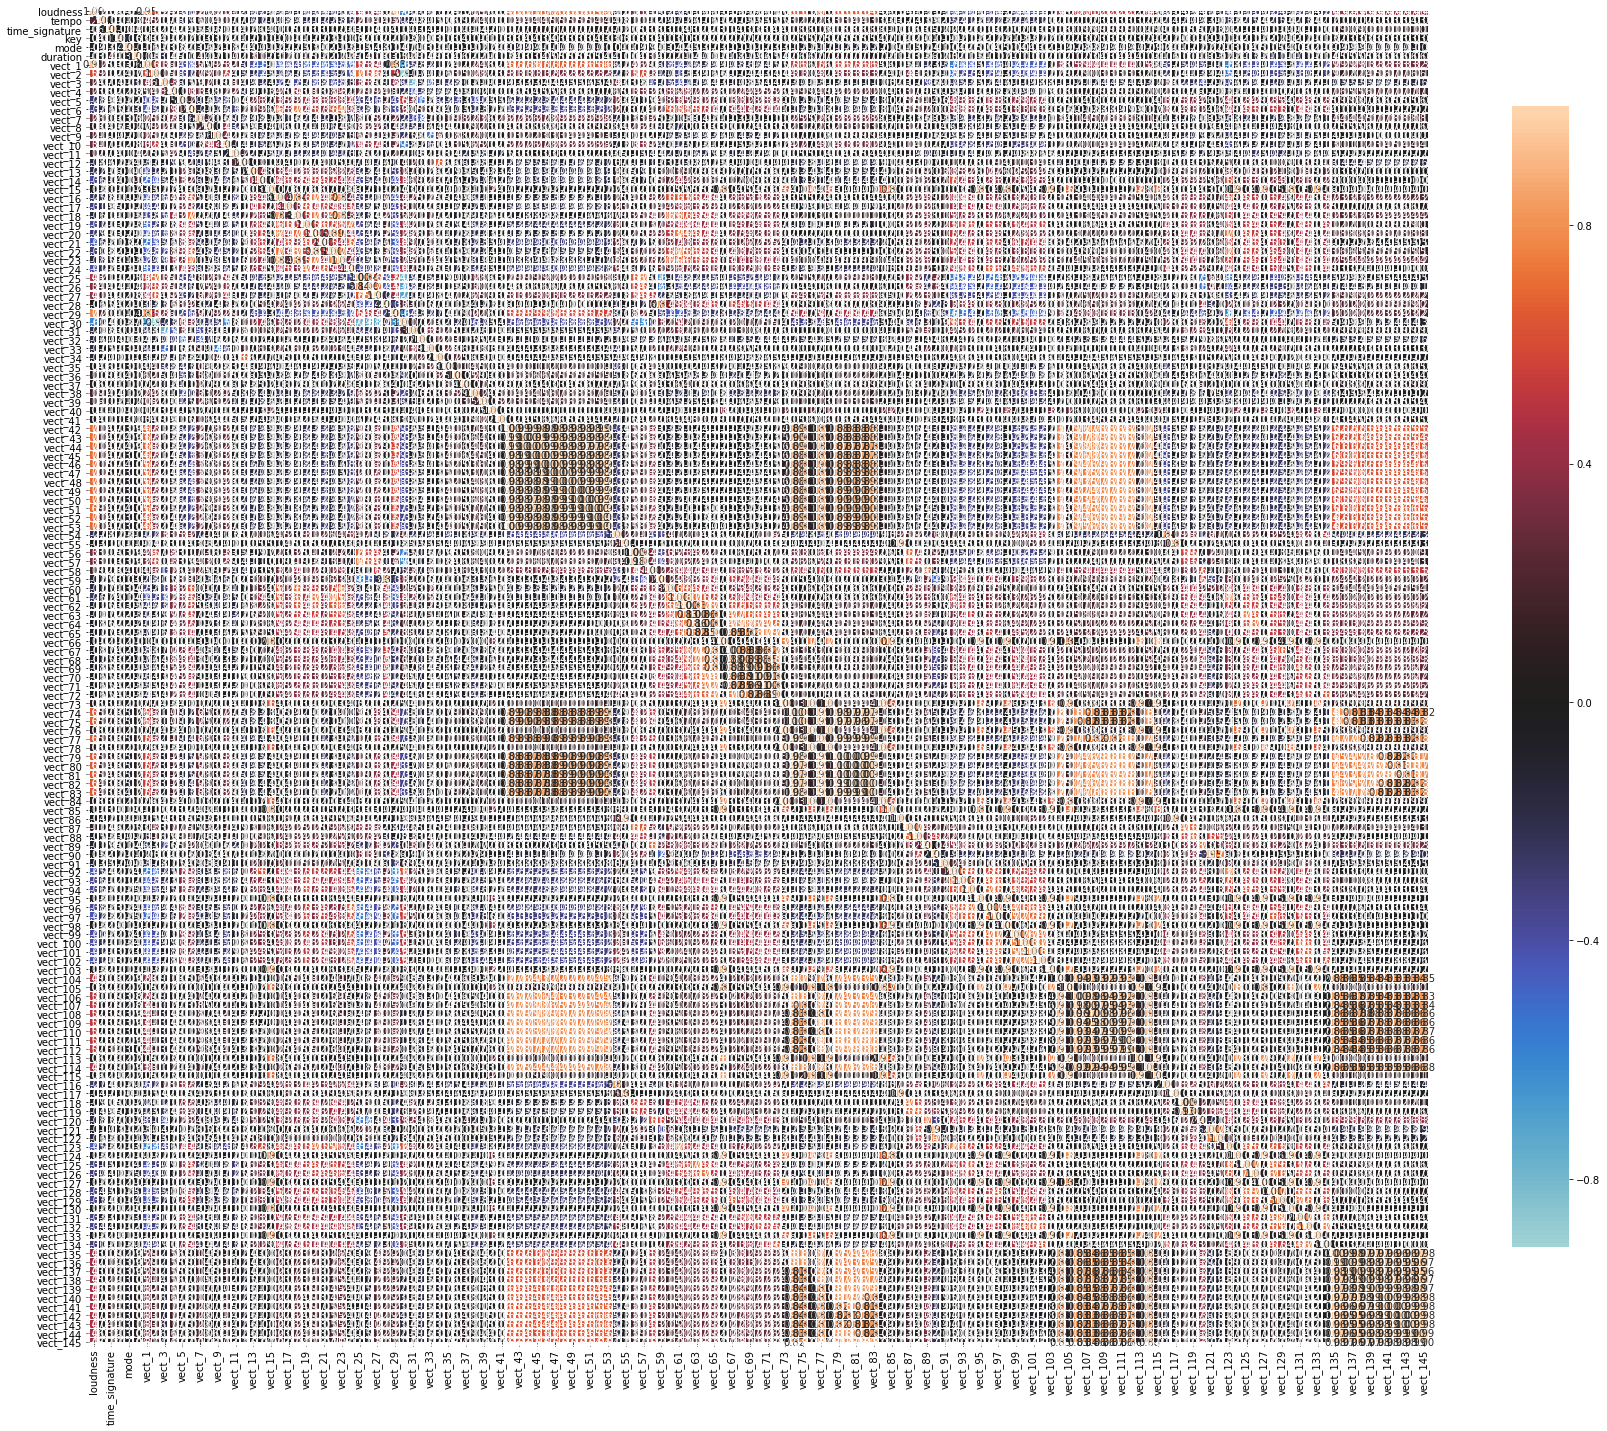

In [14]:
corr_viz1(X_train)

**From the above correlation plot, we can see some columns are more correlated. To study more about those columns, I ran correlation for those specific columns**

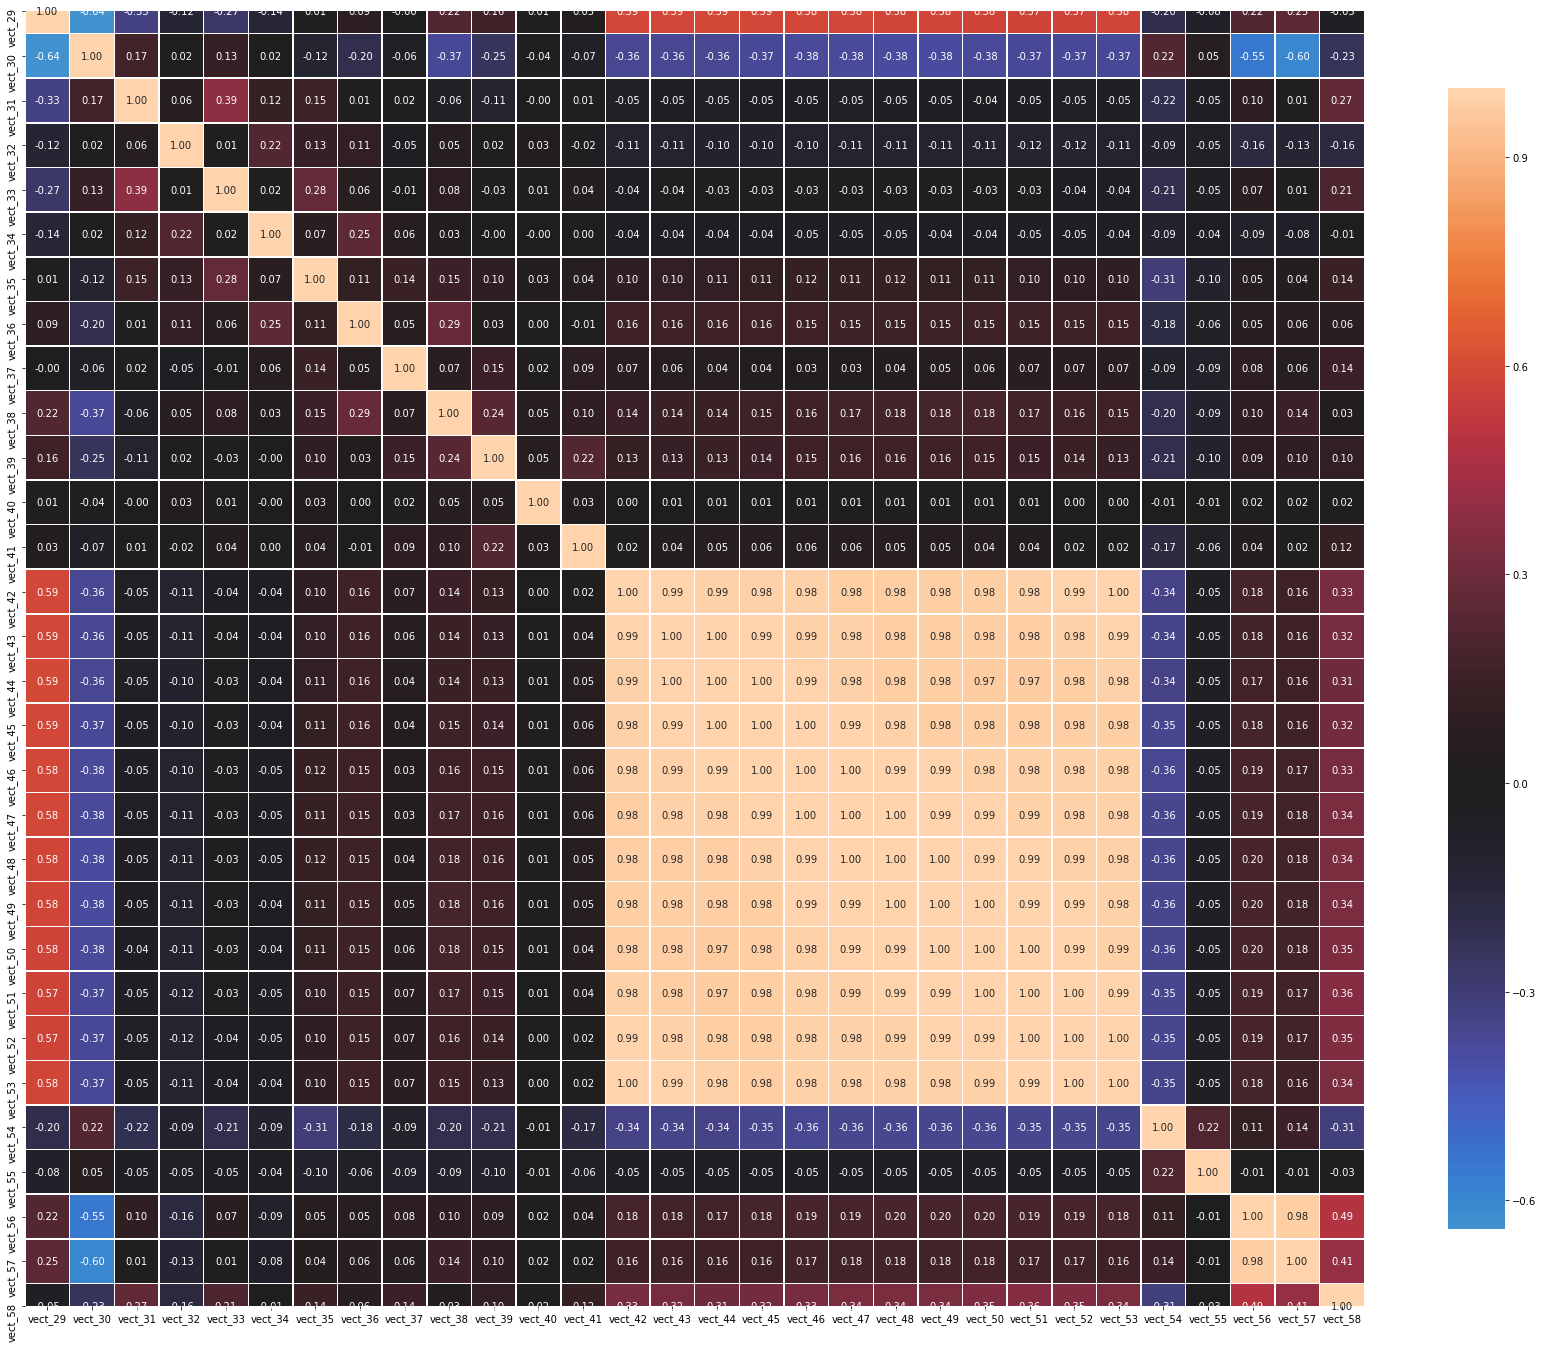

In [15]:
corr_viz2(X_train)

**Now, we can clearly see the column 42 is highly positively correlated with columns 43-52 and negatively correlated with column 54**

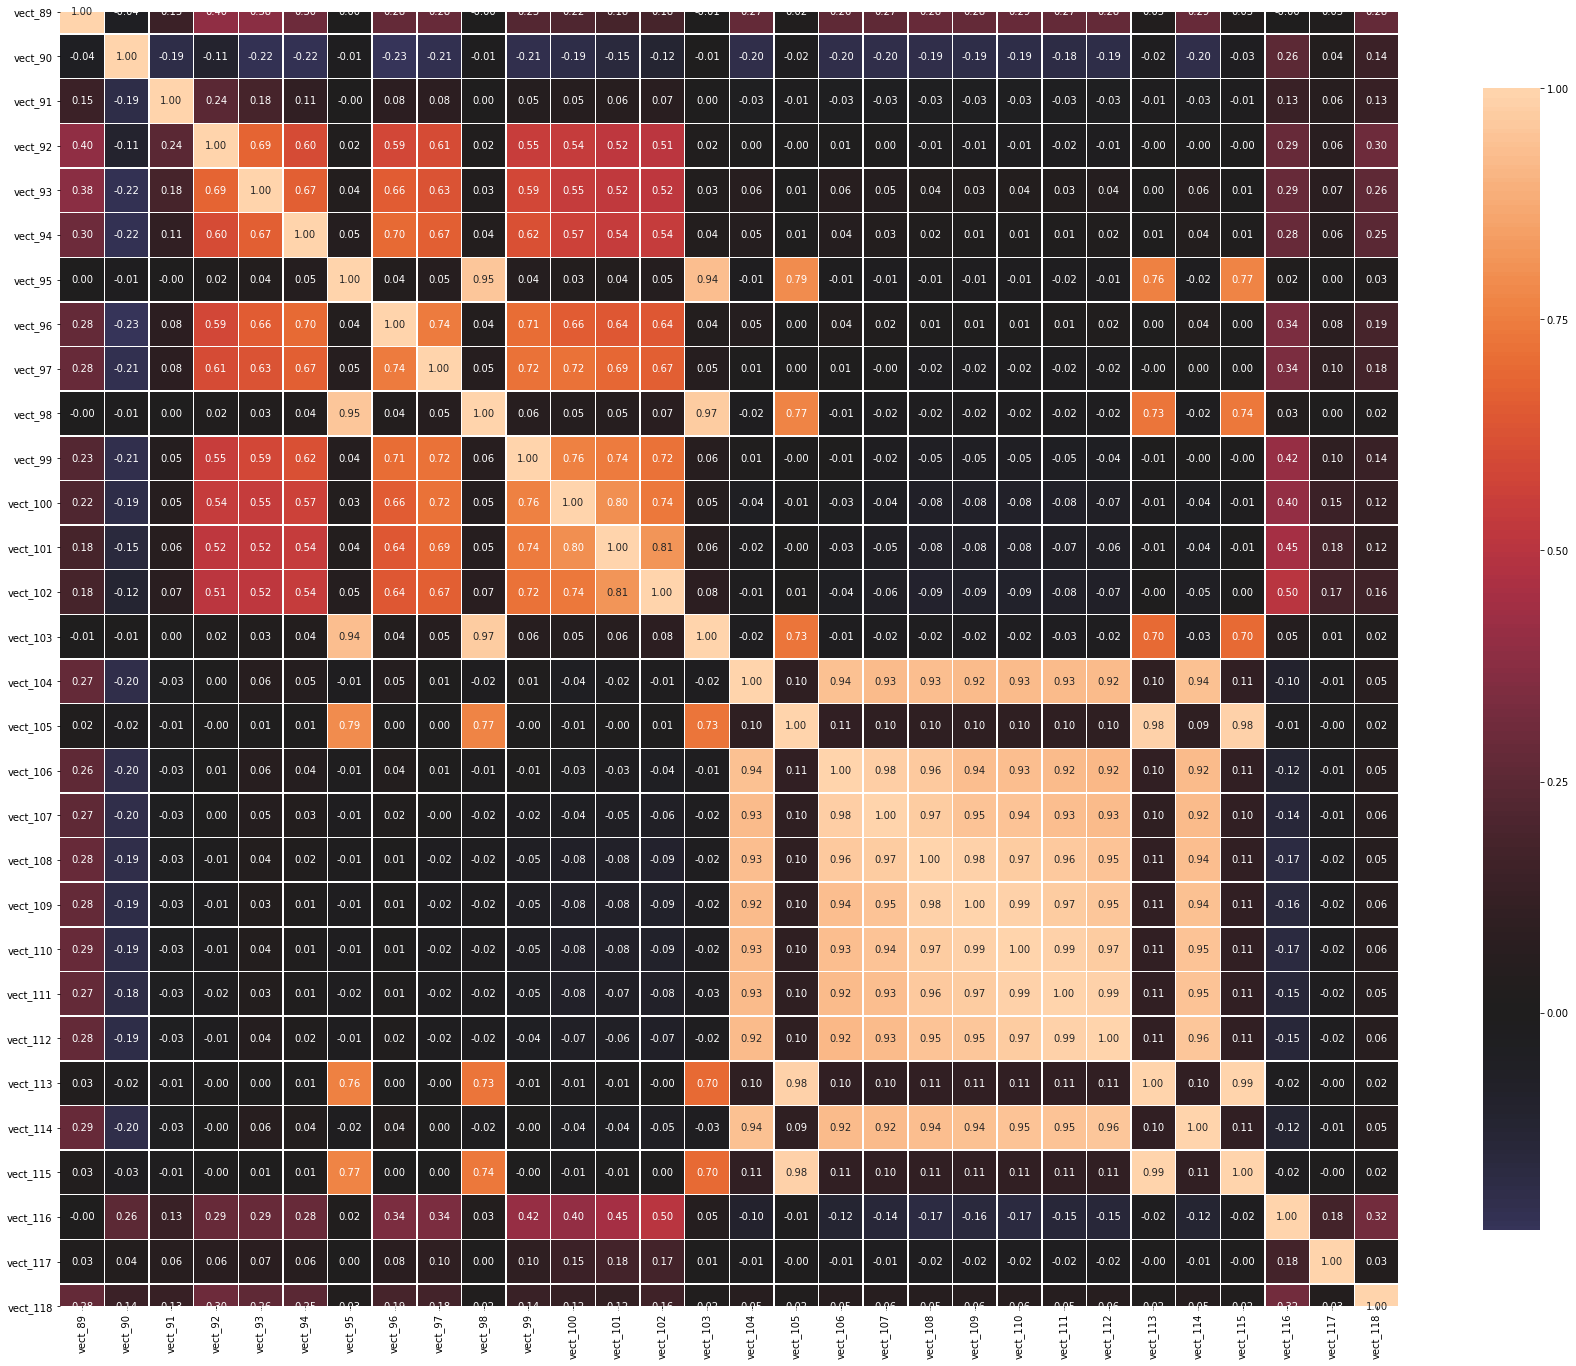

In [16]:
corr_viz4(X_train)

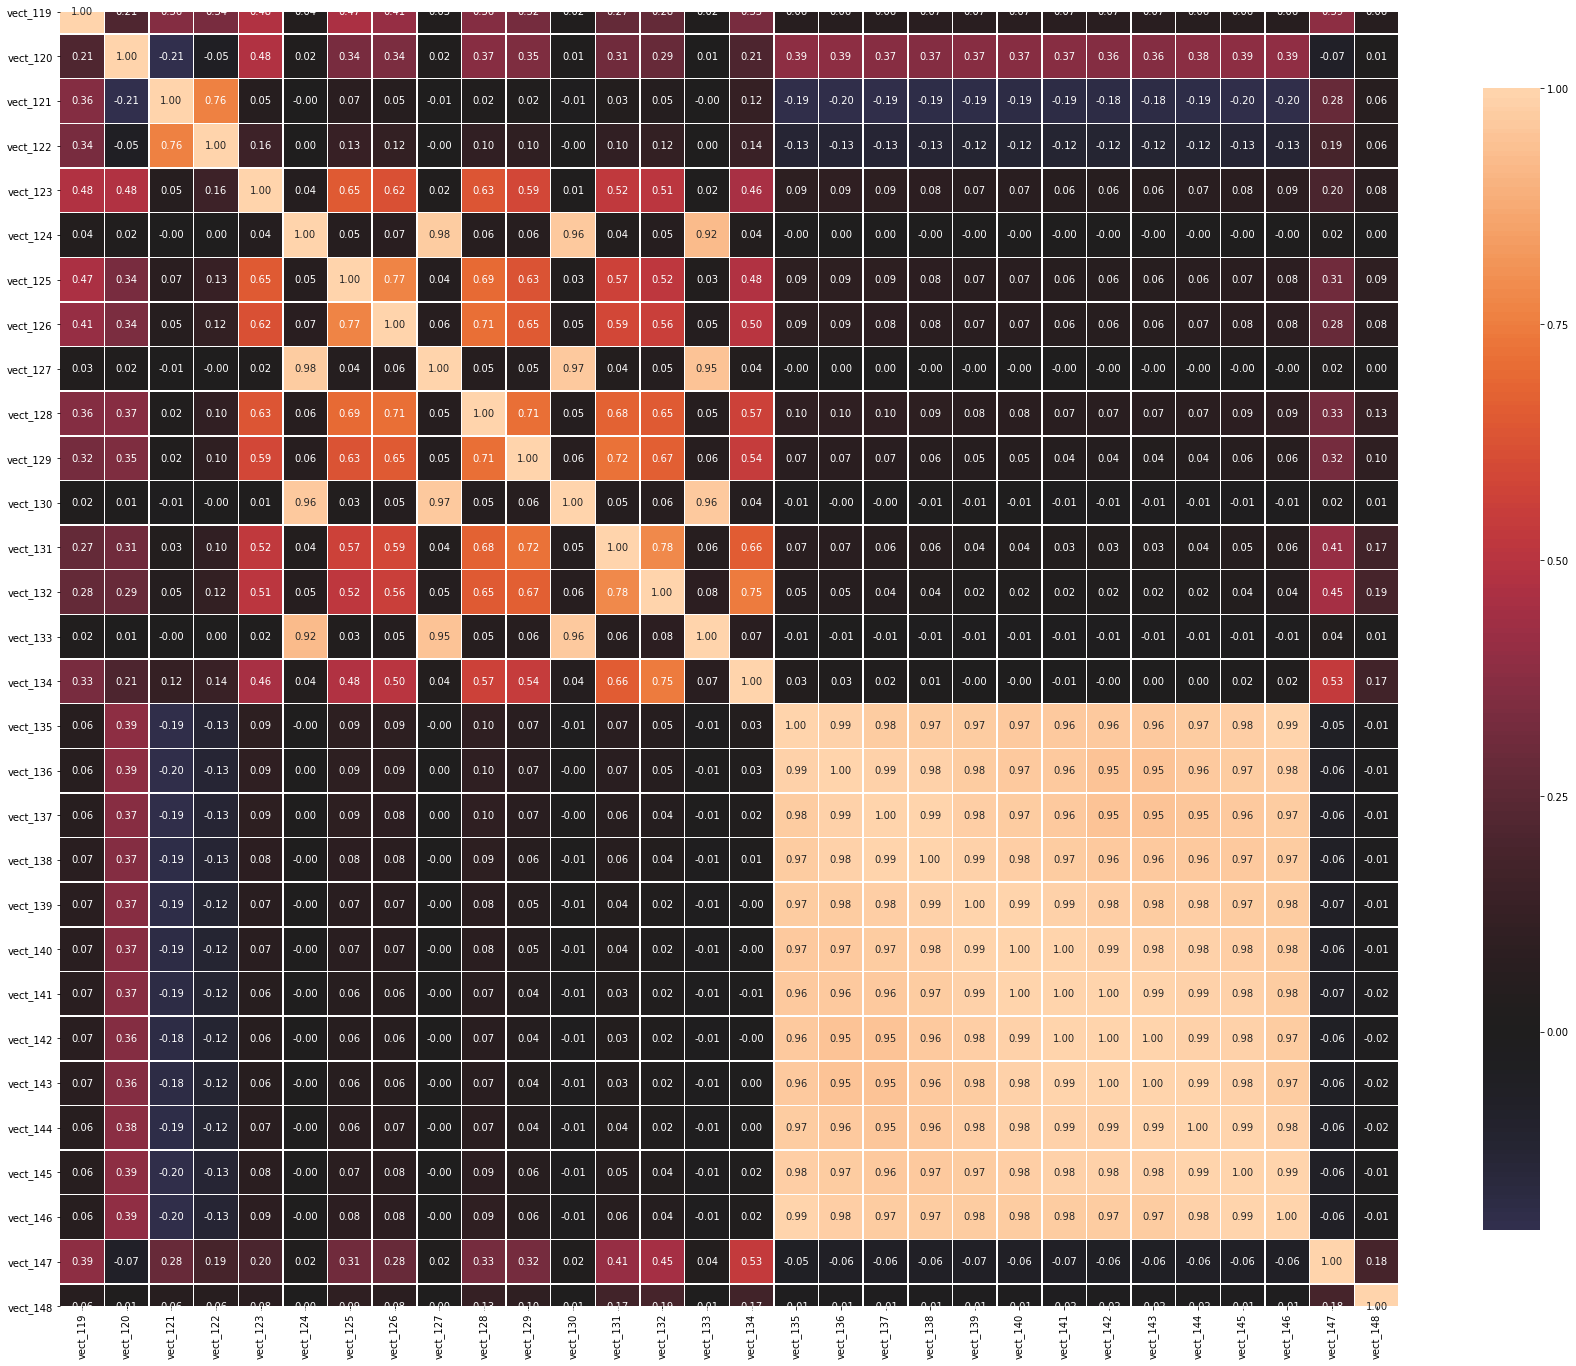

In [17]:
corr_viz5(X_train)

Similarly studied the correlation of other features, for dimentionality reduction.
Next, I studied the effect of each feature over the target column. This helps to understand feature importance.

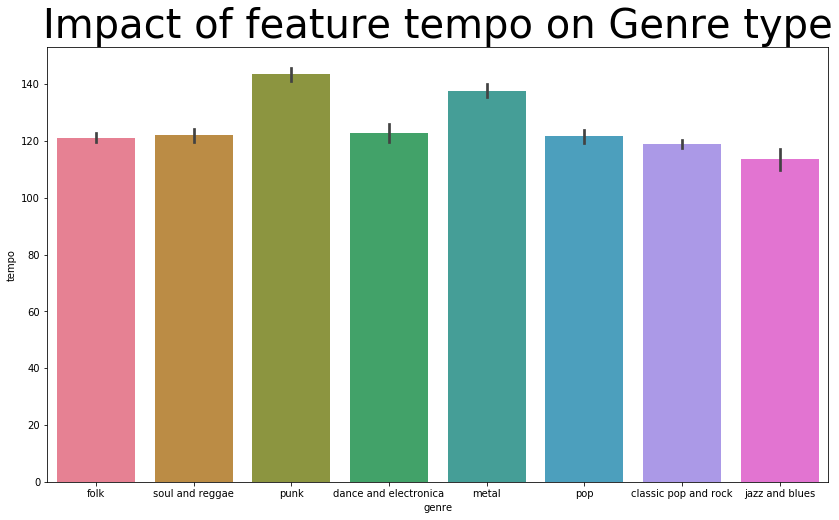

In [18]:
imp_fea_viz1(X_train)

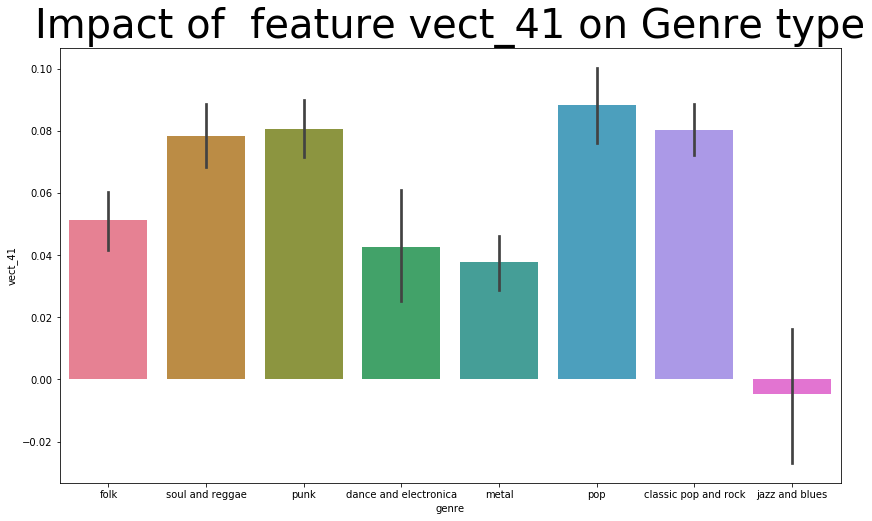

In [19]:
imp_fea_viz2(X_train)

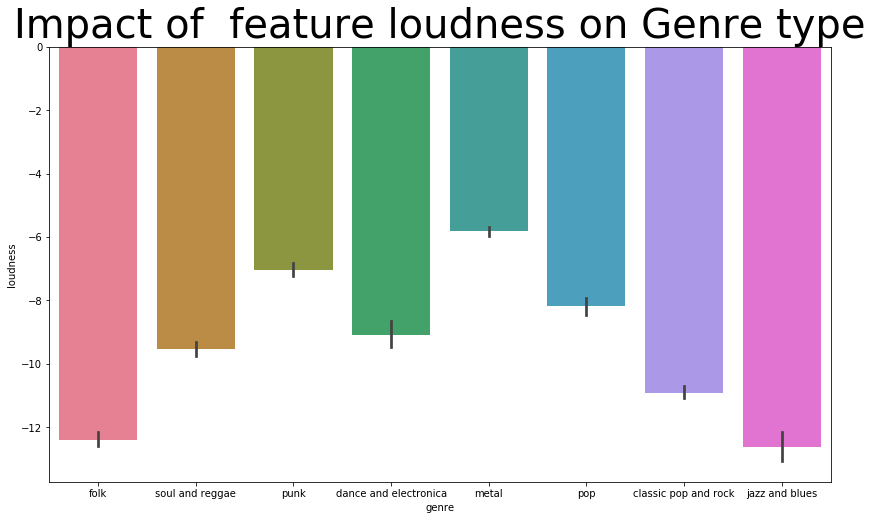

In [20]:
imp_fea_viz3(X_train)

**We can see feature 'vect_31' has a huge potential on predicting 'jazz and blues' genre. To understand such feature importance and also to reduce dimentionality,Principle Component Analysis is done.**

In [21]:
#Copy the data so that we use it later build final predictions results with trackid and title
X_train_data = X_train.copy()
Y_train_data = Y_train.copy()
X_train, X_val, Y_train, Y_val = train_test_split(X_train.iloc[:, 3:157].values, Y_train.iloc[:,-1].values, test_size=0.10, random_state=42)


In [22]:
# Function gets the models to evaluate for feature importance
models = get_models()

# Function evaluates the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, Y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>3 0.406 (0.016)
>4 0.405 (0.017)
>5 0.413 (0.016)
>6 0.421 (0.016)
>7 0.433 (0.014)
>8 0.443 (0.015)
>9 0.446 (0.016)
>10 0.454 (0.015)
>11 0.456 (0.016)
>12 0.456 (0.016)
>13 0.462 (0.016)
>14 0.467 (0.015)
>15 0.472 (0.016)
>16 0.475 (0.016)
>17 0.476 (0.015)
>18 0.482 (0.016)
>19 0.482 (0.016)
>20 0.491 (0.014)
>21 0.495 (0.015)
>22 0.498 (0.015)
>23 0.501 (0.016)
>24 0.506 (0.016)
>25 0.508 (0.017)
>26 0.511 (0.017)
>27 0.511 (0.017)
>28 0.517 (0.016)
>29 0.521 (0.016)
>30 0.525 (0.016)
>31 0.527 (0.017)
>32 0.530 (0.018)
>33 0.532 (0.018)
>34 0.541 (0.016)
>35 0.545 (0.014)
>36 0.549 (0.015)
>37 0.551 (0.016)
>38 0.553 (0.017)
>39 0.551 (0.017)
>40 0.552 (0.018)
>41 0.554 (0.019)
>42 0.555 (0.020)
>43 0.555 (0.019)
>44 0.555 (0.018)
>45 0.555 (0.017)
>46 0.556 (0.018)
>47 0.557 (0.018)
>48 0.556 (0.017)
>49 0.558 (0.019)
>50 0.559 (0.016)
>51 0.560 (0.018)
>52 0.560 (0.017)
>53 0.560 (0.018)
>54 0.561 (0.019)
>55 0.562 (0.017)
>56 0.562 (0.016)
>57 0.563 (0.017)
>58 0.564 (0.016)

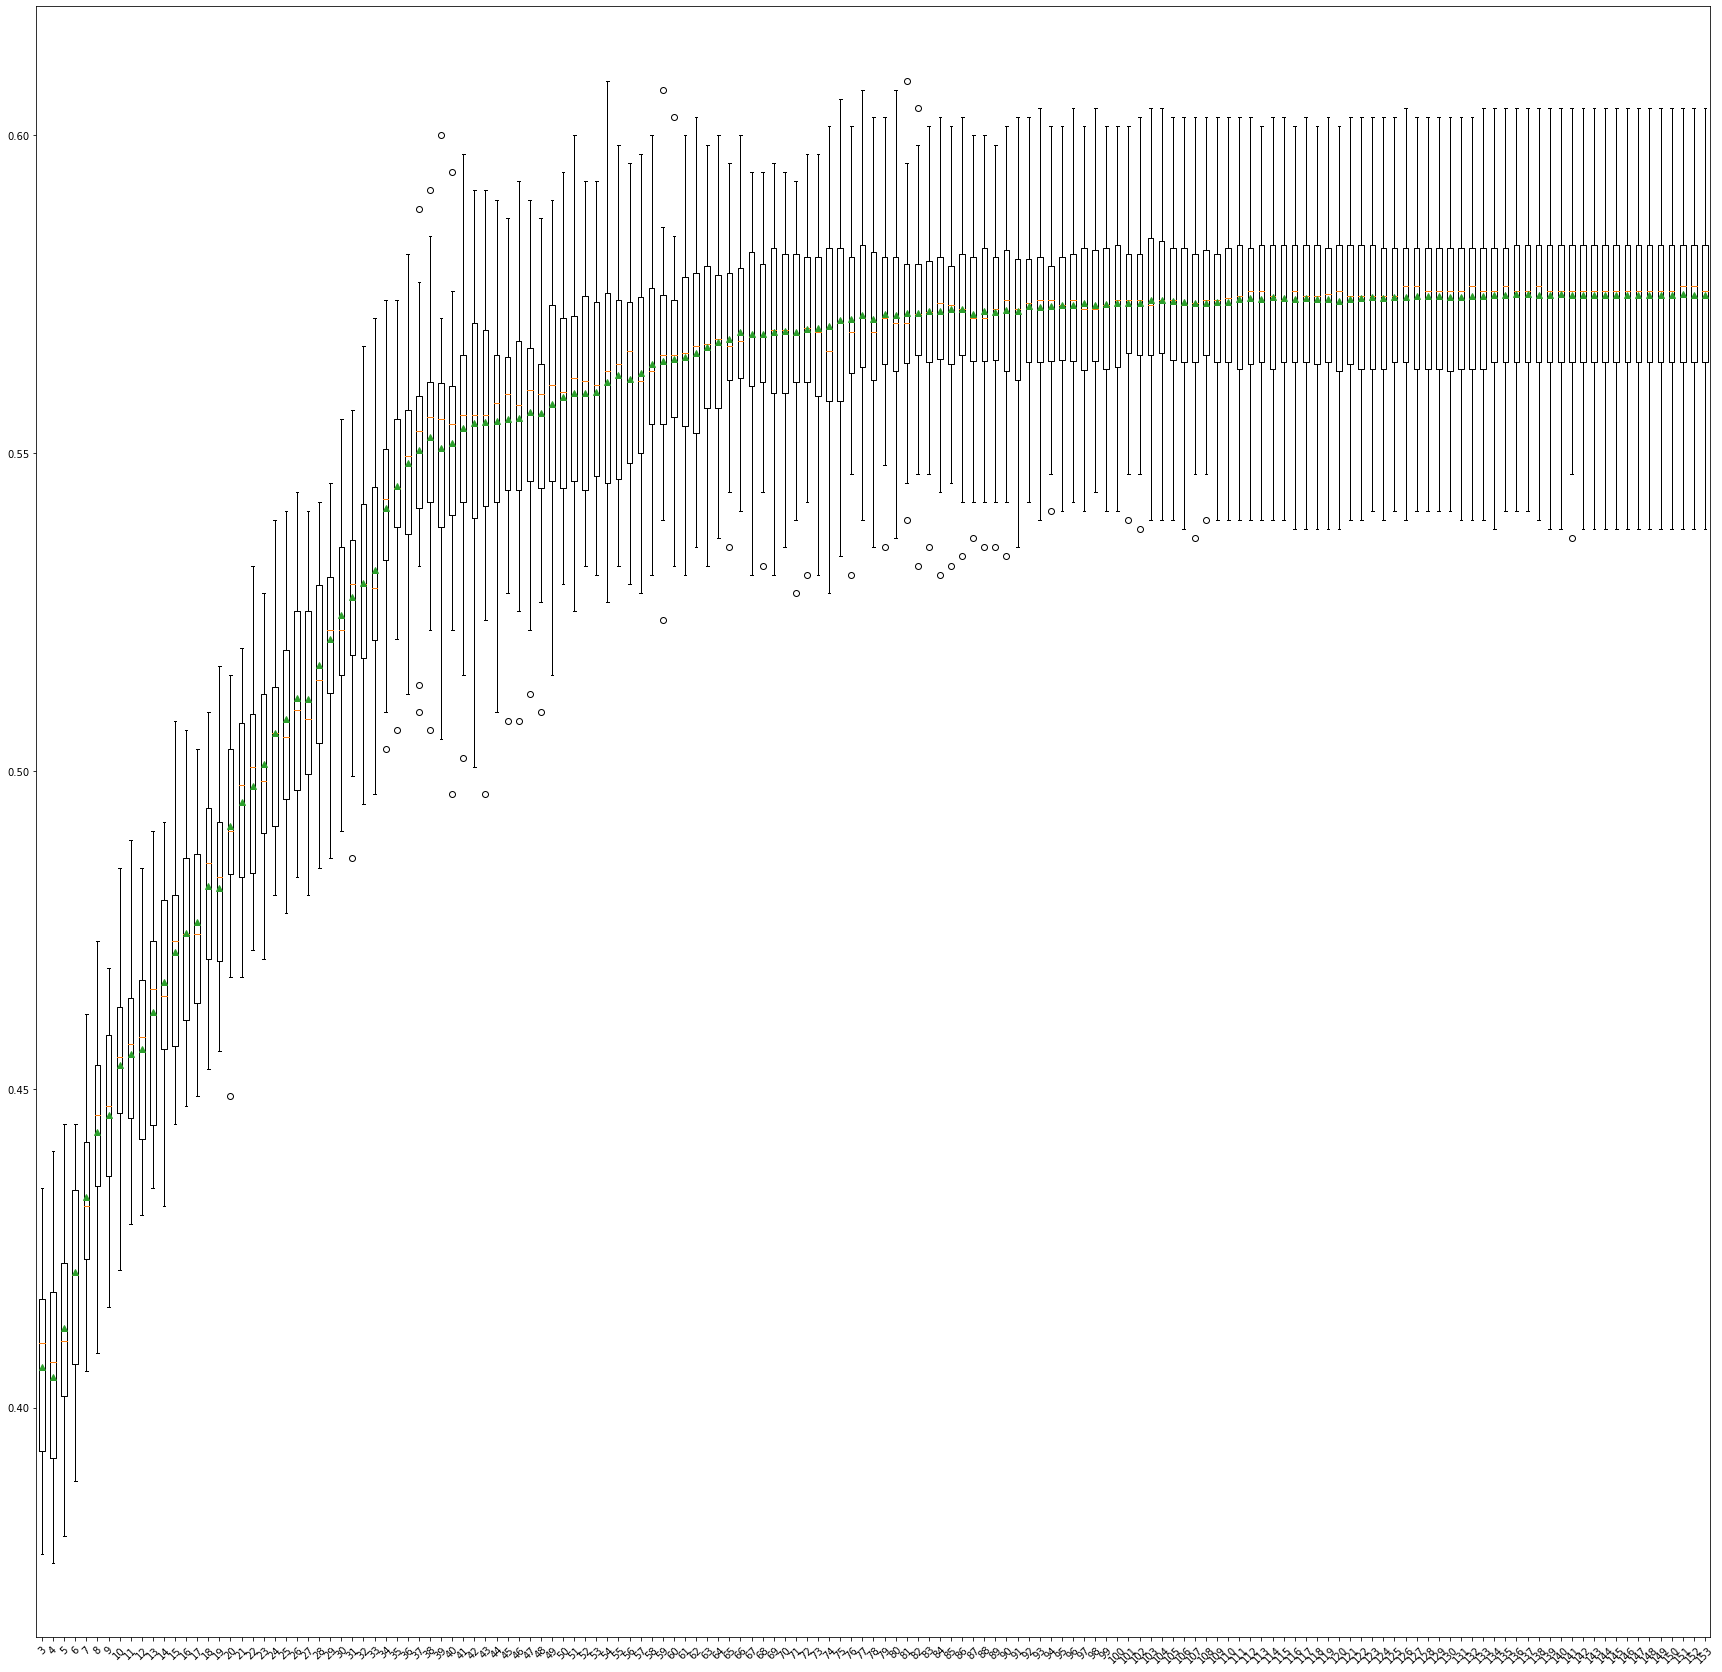

In [23]:
# plot model performance for comparison
fig, ax = plt.subplots(figsize=(30,30))
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

- From the above graph, we can cleary understand that, component 1 has most of the information.
- Value gradually increases until component 60
- After component 60, there is not much increase the model accuracy
- This gives us trade off between time and accuracy.
- Depending on the business, we can decide either more accuracy is important or model to be deployed within short period of time

### The above model is run purely to understand the feature importance. Now we can build different models with the 60 components and compare accuracy

In [24]:
#Simple Logistic Regression is run with C=1
steps = [('norm', preprocessing.MinMaxScaler()),('pca', PCA(n_components=60)), ('m', LogisticRegression(C=1,multi_class = 'ovr'))]
models = Pipeline(steps=steps)
models.fit(X_train,Y_train)
m_predict = models.predict(X_val)
m_report ="""Calculated 
Train Accuracy:{}
Validation Accuracy: {}
""".format(
           models.score(X_train, Y_train),
            metrics.accuracy_score(Y_val, m_predict))
print(m_report)
filename = 'LR_C1.bin'
pickle.dump(model, open(filename, 'wb'))

Calculated 
Train Accuracy:0.5760322255790534
Validation Accuracy: 0.5950840879689522



In [25]:
#Testing for different C values, (C value as hyper parameter tuning)
inv_log_likelihood_train=[]
inv_log_likelihood_val=[]
num_C = 10
C = [1.0] * num_C
for i in range(num_C):
    C[i] = pow(10, i-3)
    print("C-value:",C[i])
    steps = [('norm', preprocessing.MinMaxScaler()),('pca', PCA(n_components=60)), ('m', LogisticRegression(C=C[i],solver = 'newton-cg',multi_class = 'multinomial'))]
    multinom_newton_estimator = Pipeline(steps=steps)
    multinom_newton_estimator.fit(X_train,Y_train)
    m_predict = multinom_newton_estimator.predict(X_val)
    predict_probability_train = multinom_newton_estimator.predict_proba(X_train)
    predict_probability_test = multinom_newton_estimator.predict_proba(X_val)
    inv_log_likelihood_train.append(metrics.log_loss(Y_train,predict_probability_train))
    inv_log_likelihood_val.append(metrics.log_loss(Y_val,predict_probability_test))

C-value: 0.001
C-value: 0.01
C-value: 0.1
C-value: 1
C-value: 10
C-value: 100
C-value: 1000
C-value: 10000
C-value: 100000
C-value: 1000000


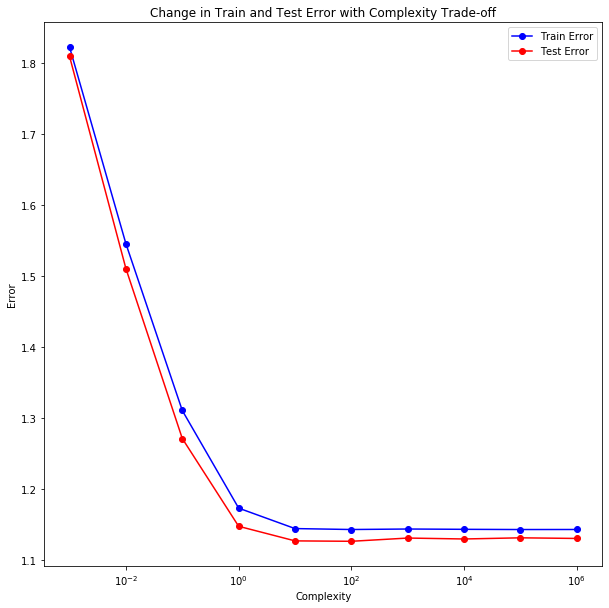

In [26]:
plt.figure(figsize = (10, 10))
plt.xscale('log')
plt.plot(C, inv_log_likelihood_train, 'bo-',C,inv_log_likelihood_val,'ro-')
plt.legend(['Train Error','Test Error'])
plt.title('Change in Train and Test Error with Complexity Trade-off')
plt.xlabel('Complexity')
plt.ylabel('Error')
plt.show()

**The above plot clearly showly that after C=10 there is not much of changes in the model. Hence we consider model will C = 10 for our classification.**

In [27]:
#Building model with C = 10
steps = [('norm', preprocessing.MinMaxScaler()),('pca', PCA(n_components=60)), ('m', LogisticRegression(C=10,solver = 'newton-cg',multi_class = 'multinomial'))]
models = Pipeline(steps=steps)
models.fit(X_train,Y_train)
m_predict = models.predict(X_val)
m_report ="""Calculated 
Train Accuracy:{}
Validation Accuracy: {}
""".format(
           models.score(X_train, Y_train),
            metrics.accuracy_score(Y_val, m_predict))
print(m_report)

filename = 'LR_C10.bin'
pickle.dump(models, open(filename, 'wb'))

Calculated 
Train Accuracy:0.594159113796576
Validation Accuracy: 0.6119016817593791



In [28]:
#Getting the data ready NN model with LSTM classifier

X_train,Y_train,X_test = get_dataset()
Y_train = Y_train.astype({"genre":'category'})
Y_train_data = Y_train.copy()
Y_train = pd.get_dummies(Y_train)
X_train_data = X_train.copy()
X_train, X_val, Y_train, Y_val = train_test_split(X_train.iloc[:, 3:157].values, Y_train.values, test_size=0.10, random_state=42)
X_test = X_test.iloc[:, 3:157].values
X_train= np.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1]))
X_val= np.reshape(X_val,(X_val.shape[0], 1, X_val.shape[1]))
X_test= np.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1]))
data_summary(X_train, Y_train, X_val, Y_val,X_test)

Train features shape: (6951, 1, 154)
Train labels shape: (6951, 8)
Validation features shape: (773, 1, 154)
Validation labels shape: (773, 8)
Test features shape: (428, 1, 154)


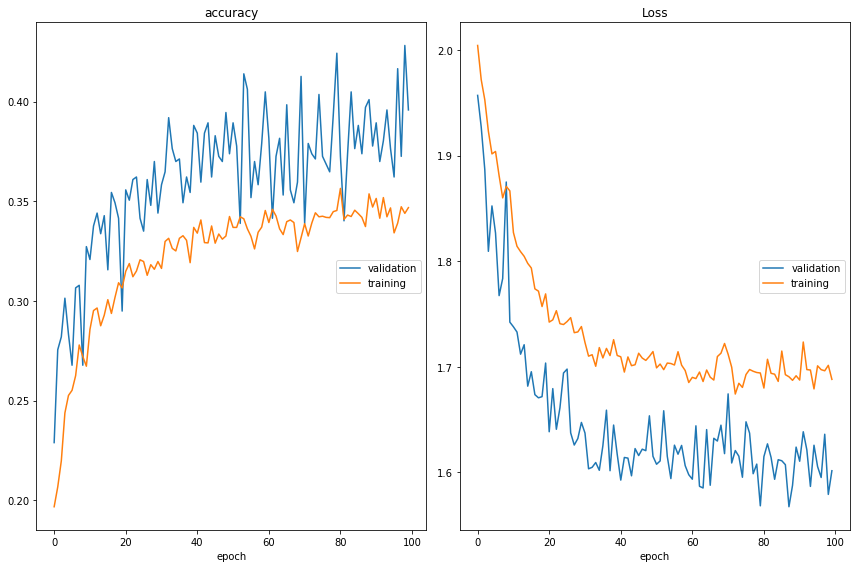

accuracy
	validation       	 (min:    0.229, max:    0.428, cur:    0.396)
	training         	 (min:    0.197, max:    0.356, cur:    0.347)
Loss
	validation       	 (min:    1.567, max:    1.957, cur:    1.601)
	training         	 (min:    1.674, max:    2.004, cur:    1.688)


In [29]:
#Building the NN model with LSTM classifier
plot_losses = livelossplot.PlotLossesKeras()
NUM_CATEGORIES = labels.genre.nunique()
#Defining the hyperparameters
epochs = 100
batch_size = 16
adam = Adam(lr=0.001, decay=0.000049, epsilon=1e-8)
model = Sequential()
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(72, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))
#if we dont one-hot encoding use sparse_categorical_crossentropy as loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,verbose = 0,callbacks =[plot_losses],validation_data=(X_val, Y_val))
model.save('NN_1.bin')

In [30]:
NN_model = load_model('NN_1.bin')
# Summary of the NN model with LSTM classifier
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                6600      
_________________________________________________________________
dense_1 (Dense)              (None, 72)                792       
_________________________________________________________________
dropout_1 (Dropout)          (None, 72)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2336      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
Total params: 9,992
Trainable params: 9,992
Non-trainable params: 0
_________________________________________________________________


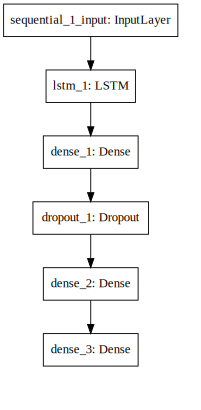

In [31]:
#NN  layer visualization
SVG(model_to_dot(NN_model,dpi=65).create(prog='dot', format='svg'))

# Model Evaluation

In [32]:
train_scores = NN_model.evaluate(X_train, Y_train)
val_scores = NN_model.evaluate(X_val, Y_val)

773/773 [==============================] - 0s 16us/step


# Make predictions on Train data to compare results

In [33]:
X_train,Y_train,X_test = get_dataset()
X_train_data = X_train.copy()
Y_train_data = Y_train.copy()
X_train, X_val, Y_train, Y_val = train_test_split(X_train.iloc[:, 3:157].values, Y_train.iloc[:,-1].values, test_size=0.10, random_state=42)


filename = 'LR_C10.bin'
LR_model = pickle.load(open(filename, 'rb'))
result = LR_model.score(X_val, Y_val)
m_predict_train = LR_model.predict(X_train)
m_predict_train = LR_model.predict(X_train_data.iloc[:, 3:157].values)
train_pred_op = pd.DataFrame(m_predict_train,columns=['predicted_genre'])
train_pred_op['title'] = X_train_data.title.tolist()
train_pred_op['actual_genre'] = X_train_data.genre.tolist()
train_pred_op = train_pred_op[['title','actual_genre','predicted_genre']]
output_dir = 'outputs/LR/'
output_file = 'train_predictions.csv'
train_pred_op.to_csv(output_dir + output_file)

# Generate final report to compare model accuracy

In [34]:
m_report ="""Calculated 
Logistic Regression Train Accuracy:{}
Logistic Regression Validation Accuracy: {}
Neural Network LSTM Classifier Train Loss:{}
Neural Network LSTM Classifier Train Accuracy:{}
Neural Network LSTM Validation Loss:{}
Neural Network LSTM Validation Accuracy: {}
""".format(
           models.score(X_train, Y_train),
            metrics.accuracy_score(Y_val, m_predict),str(train_scores[0]),str(train_scores[1]),
            str(val_scores[0]),str(val_scores[1])
    
)
print(m_report)

Calculated 
Logistic Regression Train Accuracy:0.594159113796576
Logistic Regression Validation Accuracy: 0.6119016817593791
Neural Network LSTM Classifier Train Loss:1.6433353134238142
Neural Network LSTM Classifier Train Accuracy:0.36153072118759155
Neural Network LSTM Validation Loss:1.6014713704354704
Neural Network LSTM Validation Accuracy: 0.3958602845668793



## For our Music Genre dataset, the simple logistic regression with proper feature engineering works better than a Neural network with LSTM classifier.


### Simple logistic regression
- *Train accuracy 59%*
- *validation accuracy 61%*  


### Neural network with LSTM classifier 
- *Train accuracy 36%*
- *validation accuracy 40%*

In [35]:
#Functions gets dataframe as input
def make_predictions(test_data,labels): 
    #Load the pre-trained models
    LR_model_file = 'LR_C10.bin'
    LR_model = pickle.load(open(LR_model_file, 'rb'))
    NN_model_file = 'NN_1.bin'
    NN_model = load_model('NN_1.bin')
    
    #Predict target genres on test data using LR model
    m_predict_test = LR_model.predict(test_data.iloc[:, 3:157].values)
    print('Successfully predicted LR model')
    #Store predicted classes along with its title name
    test_pred_op = pd.DataFrame(m_predict_test,columns=['predicted_genre'])
    test_pred_op['title'] = test_data.title.tolist()
    test_pred_op['trackID'] = test_data.trackID.tolist()
    test_pred_op = test_pred_op[['trackID','title','predicted_genre']]
    print('Successfully stored LR model predictions')
    #reshape input data for NN model
    X_test = test_data.iloc[:, 3:157].values
    X_test= np.reshape(X_test,(X_test.shape[0], 1, X_test.shape[1]))
    
    #Predict target genres on test data using NN model
    #This model outputs continuous values 
    NN_model_predictions = NN_model.predict_classes(X_test)
    print('Successfully predicted NN model')
    
    #Resturcture the prediction values so that it matches the genre class values
    temp_labels = pd.DataFrame(labels['genre'].unique(),columns = ['predicted_genre'])
    temp_labels =temp_labels.sort_values(by=['predicted_genre'], ascending=True)
    temp = pd.DataFrame(NN_model_predictions,columns = ['predictions'])
    NN_test_pred_op = pd.merge(temp,temp_labels,right_index=True, left_on='predictions')
    NN_test_pred_op['title'] = test_data.title.tolist()
    NN_test_pred_op['trackID'] = test_data.trackID.tolist()
    NN_test_pred_op = NN_test_pred_op[['trackID','title','predicted_genre']]
    NN_test_pred_op['predicted_genre'] = NN_test_pred_op['predicted_genre']
    print('Successfully stored NN model predictions')
    return test_pred_op,NN_test_pred_op

In [36]:
features,labels,test_data = load_data()
X_train,Y_train,X_test = get_dataset()
test_pred_op,NN_test_pred_op = make_predictions(X_test,labels)

Successfully predicted LR model
Successfully stored LR model predictions
Successfully predicted NN model
Successfully stored NN model predictions


Please refer the src folder for web application for this model implementation. I have implemented for both the models, so that we can check for correct data points from both the models.
Eventhough NN model accuracy is low, we can use it to the correctly classfied genres.


Future work, 
- Try XGBoost, which named to work well for classification models
- Try ensembling using Stacking of probabilities from different model to improve the accuracy of the final model